<h2> Creating a Spark session </h2>

In [1]:
!scala -version

Scala code runner version 2.11.12 -- Copyright 2002-2017, LAMP/EPFL


<p> we need to check the scala version so that you can include the correct version of the spark-bigquery-connector jar. </p>

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
 .appName('Steel defults classification with PySpark') \
 .getOrCreate()

In [3]:
spark

<h4> Enabling Enable repl.eagerEval </h4>
This will output the results of DataFrames in each step without the new need to show df.show() and also improves the formatting of the output

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

<h2> Import Libraries </h2>

In [5]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

<h2> Data import </h2>

In [6]:
df=spark.read.csv("gs://pyspark-project-bucket/steel_faults.csv", header=True, inferSchema=True)

In [53]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- X_Minimum: integer (nullable = true)
 |-- X_Maximum: integer (nullable = true)
 |-- Y_Minimum: integer (nullable = true)
 |-- Y_Maximum: integer (nullable = true)
 |-- Pixels_Areas: integer (nullable = true)
 |-- X_Perimeter: integer (nullable = true)
 |-- Y_Perimeter: integer (nullable = true)
 |-- Sum_of_Luminosity: integer (nullable = true)
 |-- Minimum_of_Luminosity: integer (nullable = true)
 |-- Maximum_of_Luminosity: integer (nullable = true)
 |-- Length_of_Conveyer: integer (nullable = true)
 |-- TypeOfSteel_A300: integer (nullable = true)
 |-- TypeOfSteel_A400: integer (nullable = true)
 |-- Steel_Plate_Thickness: integer (nullable = true)
 |-- Edges_Index: double (nullable = true)
 |-- Empty_Index: double (nullable = true)
 |-- Square_Index: double (nullable = true)
 |-- Outside_X_Index: double (nullable = true)
 |-- Edges_X_Index: double (nullable = true)
 |-- Edges_Y_Index: double (nullable = true)
 |-- Outside_Global_Index: dou

<h4> PySpark dataframe </h4>

In [12]:
df

X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,Pastry
645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,Pastry
829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.971,0.3426,0.3333,0.0037,0.75,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.215,Pastry
853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,Pastry
1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0,Pastry
430,441,100250,100337,630,20,87,62357,64,127,1387,0,1,40,0.62,0.3417,0.1264,0.0079,0.55,1.0,1.0,2.7993,1.0414,1.9395,0.8736,-0.2267,0.9874,Pastry
413,446,138468,138883,9052,230,432,1481991,23,199,1687,0,1,150,0.4896,0.33899999999999997,0.0795,0.0196,0.1435,0.9607,1.0,3.9567,1.5185,2.6181,0.9205,0.2791,1.0,Pastry
190,200,210936,210956,132,11,20,20007,124,172,1687,0,1,150,0.2253,0.34,0.5,0.0059,0.9091,1.0,1.0,2.1206,1.0,1.301,0.5,0.1841,0.3359,Pastry
330,343,429227,429253,264,15,26,29748,53,148,1687,0,1,150,0.3912,0.2189,0.5,0.0077,0.8667,1.0,1.0,2.4216,1.1139,1.415,0.5,-0.1197,0.5593,Pastry
74,90,779144,779308,1506,46,167,180215,53,143,1687,0,1,150,0.0877,0.4261,0.0976,0.0095,0.3478,0.982,1.0,3.1778,1.2041,2.2148,0.9024,-0.0651,1.0,Pastry


<h2> Exploratory Data Analysis </h2>

In [52]:
df.describe()

summary,_c0,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
count,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941
mean,970.0,571.1360123647604,617.9644513137558,1650684.868109222,1650738.705306543,1893.8784131890777,111.85522926326635,82.96599690880988,206312.14786192685,84.54868624420402,130.19371458011335,1459.1602266872746,0.40030911901081917,0.5996908809891809,78.73776403915508,0.33171519835136487,0.41420334878928305,0.5707671303451827,0.03336110252447184,0.6105286450283353,0.8134722308088619,0.5757341576506955,2.4923883565172686,1.3356861411643441,1.4032713034518252,0.08328763523956736,-0.1313050489438434,0.5854204533745492,null
stddev,560.4627552299975,520.690671421655,497.6274102752873,1774578.4147280124,1774590.089000212,5168.459559501142,301.2091870967001,426.48287921776455,512293.58760867827,32.134275700870326,18.690991866885447,144.5778233152924,0.49008720796047306,0.49008720796047295,55.08603169202901,0.29971174873659323,0.13726148878404607,0.27105838504756874,0.058961169352050084,0.24327691913789315,0.23427362312339234,0.48235199045248933,0.788929852524649,0.48161160942034265,0.4543451618411425,0.5008680465381179,0.148766840354052,0.33945180539295483,null
min,0,0,4,6712,6724,2,2,1,250,0,37,1227,0,0,40,0.0,0.0,0.0083,0.0015,0.0144,0.0484,0.0,0.301,0.301,0.0,-0.991,-0.9989,0.11900000000000001,Bumps
max,1940,1705,1713,12987661,12987692,152655,10449,18152,11591414,203,253,1794,1,1,300,0.9952,0.9439,1.0,0.8759,1.0,1.0,1.0,5.1837,3.0741,4.2587,0.9917,0.6421,1.0,Z_Scratch


<h3> Null and missing values in dataframe </h3>

In [58]:
### Get count of null and nan values in pyspark

from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) |col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().head()


,_c0,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4> Target classes </h4>

Our faults labels are like following ('Pastry', 'Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults')

In [17]:
faults=df.groupBy("Target").count().show()

+------------+-----+
|      Target|count|
+------------+-----+
|      Stains|   72|
|   Z_Scratch|  190|
|Other_Faults|  673|
|       Bumps|  402|
|    K_Scatch|  391|
|   Dirtiness|   55|
|      Pastry|  158|
+------------+-----+



In [20]:
labels=['Stains','Z_Scratch','Other_Faults','Bumps','K_Scatch','Dirtiness','Pastry']

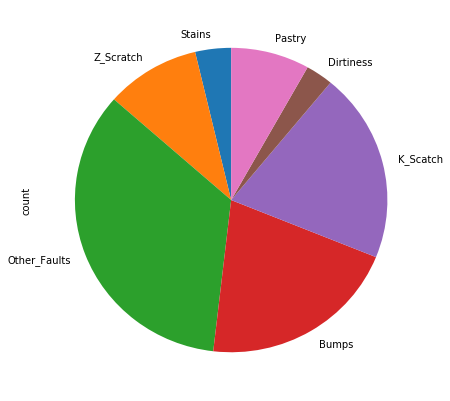

In [48]:
df.groupby('Target').count().toPandas().plot(kind='pie', y='count',labels=labels, startangle=90, figsize=(7, 7),legend=False)

<h3>Assembling features </h3>

In [51]:
from pyspark.ml.feature import VectorAssembler

# Pre-process the data
assembler = VectorAssembler(inputCols=['X_Minimum','X_Maximum','Y_Minimum','Y_Maximum','Pixels_Areas','X_Perimeter',
                                  'Y_Perimeter','Sum_of_Luminosity','Minimum_of_Luminosity','Maximum_of_Luminosity',
                                  'Length_of_Conveyer','TypeOfSteel_A300','TypeOfSteel_A400','Steel_Plate_Thickness',
                                  'Edges_Index','Empty_Index','Square_Index','Outside_X_Index','Edges_X_Index',
                                  'Edges_Y_Index','Outside_Global_Index','LogOfAreas','Log_X_Index','Log_Y_Index',
                                  'Orientation_Index','Luminosity_Index','SigmoidOfAreas'], 
                            outputCol="raw_features")
vector_df = assembler.transform(df)


<h3>Scaling features</h3>

In [52]:
from pyspark.ml.feature import StandardScaler

# Scale features to have zero mean and unit standard deviation
standarizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='raw_features',
                              outputCol='features')
model = standarizer.fit(vector_df)
vector_df = model.transform(vector_df)

In [53]:
vector_df

_c0,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target,raw_features,features
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,Pastry,"[42.0,50.0,270900...",[-1.0162194973073...
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,Pastry,"[645.0,651.0,2538...",[0.14185771262920...
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.971,0.3426,0.3333,0.0037,0.75,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.215,Pastry,"[829.0,835.0,1553...",[0.49523450637436...
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,Pastry,"[853.0,860.0,3693...",[0.54132713164547...
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0,Pastry,"[1289.0,1306.0,49...",[1.37867649073726...
5,430,441,100250,100337,630,20,87,62357,64,127,1387,0,1,40,0.62,0.3417,0.1264,0.0079,0.55,1.0,1.0,2.7993,1.0414,1.9395,0.8736,-0.2267,0.9874,Pastry,"[430.0,441.0,1002...",[-0.2710553887578...
6,413,446,138468,138883,9052,230,432,1481991,23,199,1687,0,1,150,0.4896,0.33899999999999997,0.0795,0.0196,0.1435,0.9607,1.0,3.9567,1.5185,2.6181,0.9205,0.2791,1.0,Pastry,"[413.0,446.0,1384...",[-0.3037043316581...
7,190,200,210936,210956,132,11,20,20007,124,172,1687,0,1,150,0.2253,0.34,0.5,0.0059,0.9091,1.0,1.0,2.1206,1.0,1.301,0.5,0.1841,0.3359,Pastry,"[190.0,200.0,2109...",[-0.7319816414688...
8,330,343,429227,429253,264,15,26,29748,53,148,1687,0,1,150,0.3912,0.2189,0.5,0.0077,0.8667,1.0,1.0,2.4216,1.1139,1.415,0.5,-0.1197,0.5593,Pastry,"[330.0,343.0,4292...",[-0.4631079940540...
9,74,90,779144,779308,1506,46,167,180215,53,143,1687,0,1,150,0.0877,0.4261,0.0976,0.0095,0.3478,0.982,1.0,3.1778,1.2041,2.2148,0.9024,-0.0651,1.0,Pastry,"[74.0,90.0,779144...",[-0.9547626636125...


<h3> Label encoding of Target class </h3>

In [54]:
from pyspark.ml.feature import StringIndexer

# Convert categorical label to number
indexer = StringIndexer(inputCol="Target", outputCol="label")
indexed = indexer.fit(vector_df).transform(vector_df)

In [17]:
indexed

X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target,raw_features,features,label
42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,Pastry,"[42.0,50.0,270900...",[-1.0162194973073...,4.0
645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,Pastry,"[645.0,651.0,2538...",[0.14185771262920...,4.0
829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.971,0.3426,0.3333,0.0037,0.75,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.215,Pastry,"[829.0,835.0,1553...",[0.49523450637436...,4.0
853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,Pastry,"[853.0,860.0,3693...",[0.54132713164547...,4.0
1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0,Pastry,"[1289.0,1306.0,49...",[1.37867649073726...,4.0
430,441,100250,100337,630,20,87,62357,64,127,1387,0,1,40,0.62,0.3417,0.1264,0.0079,0.55,1.0,1.0,2.7993,1.0414,1.9395,0.8736,-0.2267,0.9874,Pastry,"[430.0,441.0,1002...",[-0.2710553887578...,4.0
413,446,138468,138883,9052,230,432,1481991,23,199,1687,0,1,150,0.4896,0.33899999999999997,0.0795,0.0196,0.1435,0.9607,1.0,3.9567,1.5185,2.6181,0.9205,0.2791,1.0,Pastry,"[413.0,446.0,1384...",[-0.3037043316581...,4.0
190,200,210936,210956,132,11,20,20007,124,172,1687,0,1,150,0.2253,0.34,0.5,0.0059,0.9091,1.0,1.0,2.1206,1.0,1.301,0.5,0.1841,0.3359,Pastry,"[190.0,200.0,2109...",[-0.7319816414688...,4.0
330,343,429227,429253,264,15,26,29748,53,148,1687,0,1,150,0.3912,0.2189,0.5,0.0077,0.8667,1.0,1.0,2.4216,1.1139,1.415,0.5,-0.1197,0.5593,Pastry,"[330.0,343.0,4292...",[-0.4631079940540...,4.0
74,90,779144,779308,1506,46,167,180215,53,143,1687,0,1,150,0.0877,0.4261,0.0976,0.0095,0.3478,0.982,1.0,3.1778,1.2041,2.2148,0.9024,-0.0651,1.0,Pastry,"[74.0,90.0,779144...",[-0.9547626636125...,4.0


In [103]:
Indexing = indexed.select("Target","label").distinct()
Indexing

Target,label
Dirtiness,6.0
Stains,5.0
Bumps,1.0
Pastry,4.0
Z_Scratch,3.0
K_Scatch,2.0
Other_Faults,0.0


<h3> Train Test split </h3>

In [55]:
# Select features and labels dataset to inject to the model
data = indexed.select(['features', 'label'])

# train test split 
train, test = data.randomSplit([0.7, 0.3])

In [56]:
print(f"Train set length: {train.count()} records")
print(f"Test set length: {test.count()} records")

Train set length: 1383 records
Test set length: 558 records


<h3>Cross validation </h3>

Cross-validation is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Evaluate model
rfevaluator = MulticlassClassificationEvaluator(metricName="f1")

# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(rf.maxBins, [10, 20, 40, 80, 100])
             .addGrid(rf.numTrees, [5, 20, 50, 100, 500])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

# Run cross validations.
rfcvModel = rfcv.fit(train)
print(rfcvModel)

# Use test set here so we can measure the accuracy of our model on new data
rfpredictions = rfcvModel.transform(test)


In [81]:
rfpredictions.toPandas().head(10)

,features,label,rawPrediction,probability,prediction
0,"[-1.0968815915318277, -1.233783426387449, -0.8...",0.0,"[23.0, 4.0, 0.0, 9.0, 12.0, 0.0, 2.0]","[0.46, 0.08, 0.0, 0.18, 0.24, 0.0, 0.04]",0.0
1,"[-1.0968815915318277, -1.229764355173318, 0.72...",3.0,"[15.0, 6.0, 0.0, 23.0, 5.0, 0.0, 1.0]","[0.3, 0.12, 0.0, 0.46, 0.1, 0.0, 0.02]",3.0
2,"[-1.0968815915318277, -1.2237357483521212, -0....",2.0,"[16.0, 0.0, 33.0, 0.0, 1.0, 0.0, 0.0]","[0.32, 0.0, 0.66, 0.0, 0.02, 0.0, 0.0]",2.0
3,"[-1.0968815915318277, -1.2156976059238591, -0....",0.0,"[23.0, 0.0, 1.0, 8.0, 13.0, 0.0, 5.0]","[0.46, 0.0, 0.02, 0.16, 0.26, 0.0, 0.1]",0.0
4,"[-1.0968815915318277, -1.2136880703167936, -0....",0.0,"[48.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.96, 0.02, 0.0, 0.0, 0.0, 0.0, 0.02]",0.0
5,"[-1.0968815915318277, -1.2096689991026626, 0.6...",3.0,"[5.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0]","[0.1, 0.0, 0.0, 0.9, 0.0, 0.0, 0.0]",3.0
6,"[-1.0968815915318277, -1.207659463495597, -0.4...",0.0,"[18.0, 6.0, 5.0, 12.0, 4.0, 0.0, 5.0]","[0.36, 0.12, 0.1, 0.24, 0.08, 0.0, 0.1]",0.0
7,"[-1.0968815915318277, -1.1996213210673348, -0....",0.0,"[39.0, 3.0, 0.0, 3.0, 1.0, 0.0, 4.0]","[0.78, 0.06, 0.0, 0.06, 0.02, 0.0, 0.08]",0.0
8,"[-1.0968815915318277, -1.1996213210673348, -0....",0.0,"[41.0, 5.0, 0.0, 2.0, 2.0, 0.0, 0.0]","[0.82, 0.1, 0.0, 0.04, 0.04, 0.0, 0.0]",0.0
9,"[-1.0968815915318277, -1.1875641074249417, -0....",0.0,"[43.0, 5.0, 0.0, 2.0, 0.0, 0.0, 0.0]","[0.86, 0.1, 0.0, 0.04, 0.0, 0.0, 0.0]",0.0


In [82]:
# Select example rows to display.
rfpredictions.select("features","prediction", "label").toPandas().head(10)

,features,prediction,label
0,"[-1.0968815915318277, -1.233783426387449, -0.8...",0.0,0.0
1,"[-1.0968815915318277, -1.229764355173318, 0.72...",3.0,3.0
2,"[-1.0968815915318277, -1.2237357483521212, -0....",2.0,2.0
3,"[-1.0968815915318277, -1.2156976059238591, -0....",0.0,0.0
4,"[-1.0968815915318277, -1.2136880703167936, -0....",0.0,0.0
5,"[-1.0968815915318277, -1.2096689991026626, 0.6...",3.0,3.0
6,"[-1.0968815915318277, -1.207659463495597, -0.4...",0.0,0.0
7,"[-1.0968815915318277, -1.1996213210673348, -0....",0.0,0.0
8,"[-1.0968815915318277, -1.1996213210673348, -0....",0.0,0.0
9,"[-1.0968815915318277, -1.1875641074249417, -0....",0.0,0.0


<h2>Model evaluation </h2>

<h3> F1 score </h3>

F1 score is usually more useful than accuracy, especially if you have an **uneven class distribution**. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

In [85]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
f1= MulticlassClassificationEvaluator(labelCol ='label',predictionCol = "prediction",metricName="f1")
print('f1:', f1.evaluate(rfpredictions))

f1: 0.7565794715891656


<h3> Confusion Matrix </h3>

In [107]:
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = rfpredictions.select('label', 'prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

confusion_matrix = metrics.confusionMatrix().toArray()
labels = [int(l) for l in metrics.call('labels')]
confusion_matrix = pd.DataFrame(confusion_matrix , index=labels, columns=labels)

In [94]:
confusion_matrix

,0,1,2,3,4,5,6
0,143.0,29.0,6.0,16.0,16.0,1.0,3.0
1,35.0,66.0,1.0,2.0,4.0,1.0,0.0
2,5.0,1.0,108.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,52.0,0.0,0.0,0.0
4,5.0,5.0,0.0,0.0,25.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,18.0,0.0
6,2.0,0.0,0.0,0.0,0.0,0.0,9.0


<h3>Model metrics by class</h3>

**Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations. (Precision = TP/(TP+FP))

**Recall (Sensitivity)** is the ratio of correctly predicted positive observations to the all observations in actual class (Recall = TP/(TP+FN))

**F1 score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. (F1 Score = 2*(Recall * Precision) / (Recall + Precision))



In [117]:
# Statistics by class
labels = rfpredictions.rdd.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print("_____________________________________________________________")

Class 0.0 precision = 0.7371134020618557
Class 0.0 recall = 0.6682242990654206
Class 0.0 F1 Measure = 0.7009803921568628
_____________________________________________________________
Class 1.0 precision = 0.6534653465346535
Class 1.0 recall = 0.6055045871559633
Class 1.0 F1 Measure = 0.6285714285714286
_____________________________________________________________
Class 2.0 precision = 0.9310344827586207
Class 2.0 recall = 0.9473684210526315
Class 2.0 F1 Measure = 0.9391304347826087
_____________________________________________________________
Class 3.0 precision = 0.7428571428571429
Class 3.0 recall = 0.9454545454545454
Class 3.0 F1 Measure = 0.8320000000000001
_____________________________________________________________
Class 4.0 precision = 0.5555555555555556
Class 4.0 recall = 0.7142857142857143
Class 4.0 F1 Measure = 0.6250000000000001
_____________________________________________________________
Class 5.0 precision = 0.9
Class 5.0 recall = 0.9
Class 5.0 F1 Measure = 0.9
_________

<h2>Random Forset classifier</h2>

In [127]:
#Random forst model 
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=1000)


In [128]:
model= rf.fit(train)

In [22]:
# Make predictions.
predictions = model.transform(test)

In [23]:
predictions

features,label,rawPrediction,probability,prediction
[-1.0968815915318...,0.0,[449.234777914726...,[0.44923477791472...,0.0
[-1.0968815915318...,0.0,[462.283916091612...,[0.46228391609161...,0.0
[-1.0968815915318...,0.0,[431.842765472663...,[0.43184276547266...,0.0
[-1.0968815915318...,0.0,[470.535909185992...,[0.47053590918599...,0.0
[-1.0968815915318...,3.0,[282.038923913319...,[0.28203892391331...,3.0
[-1.0968815915318...,0.0,[502.457118669489...,[0.50245711866948...,0.0
[-1.0968815915318...,0.0,[527.985738510205...,[0.52798573851020...,0.0
[-1.0968815915318...,0.0,[498.819383953122...,[0.49881938395312...,0.0
[-1.0968815915318...,2.0,[12.2839093659508...,[0.01228390936595...,2.0
[-1.0949610654788...,0.0,[543.645321296775...,[0.54364532129677...,0.0


In [24]:
# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[-1.0968815915318...|
|       0.0|  0.0|[-1.0968815915318...|
|       0.0|  0.0|[-1.0968815915318...|
|       0.0|  0.0|[-1.0968815915318...|
|       3.0|  3.0|[-1.0968815915318...|
+----------+-----+--------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

print("Accuracy = %g" % accuracy)

Test Error = 0.318105
Accuracy = 0.681895
